# Project: Dog vs Cat Classification

In [313]:
from pathlib import Path
import os
import torch
from torch import nn

In [314]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [315]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [316]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (375, 500, 3)')

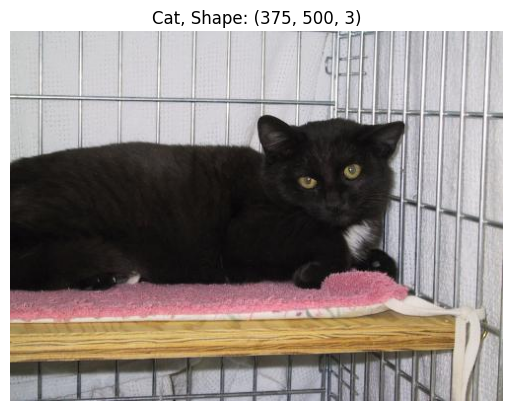

In [317]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [318]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [319]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [320]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.7804, 0.7569, 0.7882,  ..., 0.7922, 0.7882, 0.7843],
         [0.7804, 0.7569, 0.7882,  ..., 0.7961, 0.7922, 0.7882],
         [0.7843, 0.7569, 0.7882,  ..., 0.7922, 0.7922, 0.7843],
         ...,
         [0.5725, 0.7176, 0.7373,  ..., 0.6275, 0.6118, 0.6078],
         [0.5647, 0.7137, 0.7373,  ..., 0.6353, 0.6235, 0.6196],
         [0.5529, 0.7059, 0.7333,  ..., 0.5961, 0.6000, 0.6078]],

        [[0.7804, 0.7569, 0.7882,  ..., 0.8000, 0.7961, 0.7922],
         [0.7804, 0.7569, 0.7882,  ..., 0.8000, 0.8000, 0.7961],
         [0.7843, 0.7529, 0.7843,  ..., 0.8000, 0.8000, 0.7922],
         ...,
         [0.5686, 0.7098, 0.7255,  ..., 0.6392, 0.6235, 0.6196],
         [0.5569, 0.7059, 0.7294,  ..., 0.6471, 0.6392, 0.6314],
         [0.5373, 0.6980, 0.7294,  ..., 0.6078, 0.6196, 0.6118]],

        [[0.7843, 0.7647, 0.8000,  ..., 0.7961, 0.7922, 0.7882],
         [0.7843, 0.7647, 0.8000,  ..., 0.8000, 0.7961, 0.7922],
         [0.7882, 0.7647, 0.7961,  ..., 0.8000, 0.7961, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

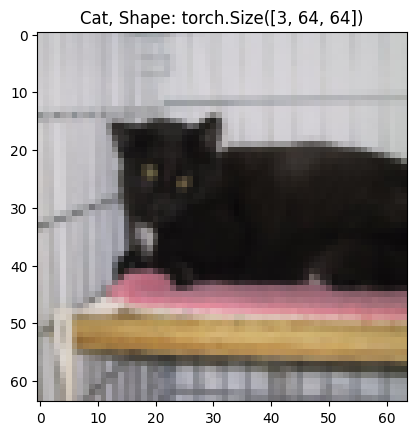

In [321]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [322]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5647
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1352
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [323]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [324]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [325]:
len(train_data), len(test_data)

(5647, 1352)

# Turn loaded images into 'DataLoader'

In [326]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25c34c03c10>,
 <torch.utils.data.dataloader.DataLoader at 0x25c50a74d90>)

In [327]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [328]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [329]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [330]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [331]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.2525],
        [-0.0125],
        [ 0.0183],
        [ 0.0891],
        [-0.0088],
        [-0.0749],
        [ 0.2087],
        [-0.0450],
        [ 0.1134],
        [ 0.2615],
        [ 0.1085],
        [ 0.1941],
        [ 0.1408],
        [ 0.1429],
        [ 0.1446],
        [ 0.1884],
        [ 0.2114],
        [ 0.1708],
        [ 0.1977],
        [ 0.1397],
        [ 0.4120],
        [ 0.1774],
        [ 0.4011],
        [ 0.1454],
        [ 0.3494],
        [-0.0031],
        [ 0.1865],
        [-0.2445],
        [ 0.0802],
        [-0.0315],
        [-0.0363],
        [-0.1412]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [332]:
from tqdm import tqdm
import time

In [333]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\piotr\anaconda3\envs\test\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 1/1 [00:16<00:00, 16.28s/it]

Epoch: 0 | Train Loss: 1.0036, Train Accuracy: 61.05 | Test Loss: 0.6275953924240067, Test Accuracy: 64.97093023255815
Total time: 16.279531002044678


# Plot model_0 results

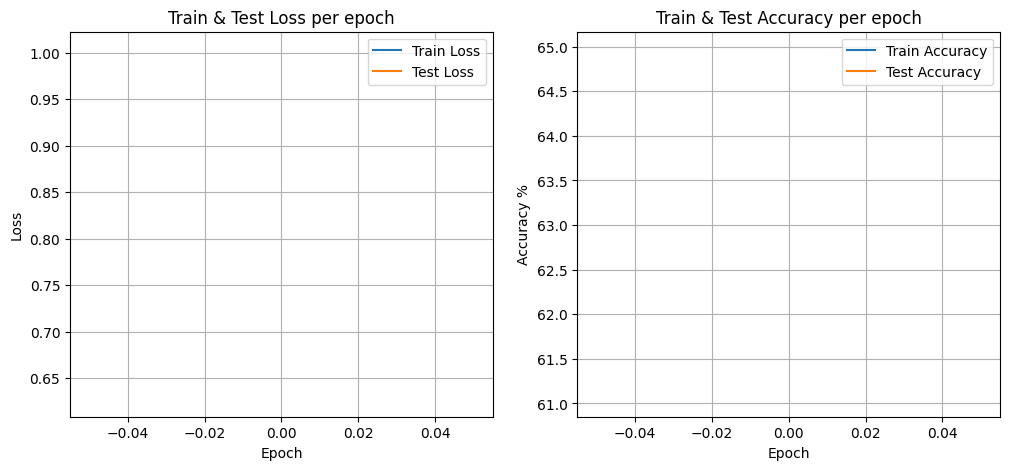

In [334]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [335]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [336]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [337]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [339]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [340]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 5647
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 1352
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5

In [341]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x25c50d000a0>,
 <torch.utils.data.dataloader.DataLoader at 0x25c50e6e490>)

In [342]:
len(class_names)

2

In [343]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [344]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [345]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:31<25:21, 31.06s/it]

Epoch: 0 | Train Loss: 0.7710, Train Accuracy: 57.61 | Test Loss: 0.6221, Test Accuracy: 63.39


  4%|▍         | 2/50 [00:56<22:09, 27.70s/it]

Epoch: 1 | Train Loss: 0.6264, Train Accuracy: 64.99 | Test Loss: 0.5845, Test Accuracy: 68.05


  6%|▌         | 3/50 [01:21<20:37, 26.32s/it]

Epoch: 2 | Train Loss: 0.6107, Train Accuracy: 66.23 | Test Loss: 0.5723, Test Accuracy: 69.97


  8%|▊         | 4/50 [01:52<21:39, 28.25s/it]

Epoch: 3 | Train Loss: 0.5824, Train Accuracy: 68.43 | Test Loss: 0.6185, Test Accuracy: 68.49


 10%|█         | 5/50 [02:24<22:18, 29.75s/it]

Epoch: 4 | Train Loss: 0.5665, Train Accuracy: 69.52 | Test Loss: 0.5486, Test Accuracy: 72.71


 12%|█▏        | 6/50 [02:57<22:29, 30.67s/it]

Epoch: 5 | Train Loss: 0.5572, Train Accuracy: 71.17 | Test Loss: 0.5289, Test Accuracy: 73.59


 14%|█▍        | 7/50 [03:29<22:23, 31.24s/it]

Epoch: 6 | Train Loss: 0.5463, Train Accuracy: 72.04 | Test Loss: 0.5198, Test Accuracy: 75.15


 16%|█▌        | 8/50 [04:00<21:50, 31.19s/it]

Epoch: 7 | Train Loss: 0.5300, Train Accuracy: 73.17 | Test Loss: 0.5616, Test Accuracy: 69.67


 18%|█▊        | 9/50 [04:32<21:25, 31.36s/it]

Epoch: 8 | Train Loss: 0.5173, Train Accuracy: 74.30 | Test Loss: 0.4932, Test Accuracy: 78.03


 20%|██        | 10/50 [05:05<21:11, 31.79s/it]

Epoch: 9 | Train Loss: 0.5195, Train Accuracy: 73.65 | Test Loss: 0.5242, Test Accuracy: 74.63


 22%|██▏       | 11/50 [05:36<20:40, 31.80s/it]

Epoch: 10 | Train Loss: 0.5007, Train Accuracy: 75.54 | Test Loss: 0.5909, Test Accuracy: 69.30


 24%|██▍       | 12/50 [06:07<19:53, 31.40s/it]

Epoch: 11 | Train Loss: 0.4966, Train Accuracy: 76.20 | Test Loss: 0.4519, Test Accuracy: 79.88


 26%|██▌       | 13/50 [06:32<18:15, 29.62s/it]

Epoch: 12 | Train Loss: 0.4831, Train Accuracy: 76.59 | Test Loss: 0.5240, Test Accuracy: 74.70


 28%|██▊       | 14/50 [06:58<17:05, 28.50s/it]

Epoch: 13 | Train Loss: 0.4679, Train Accuracy: 77.97 | Test Loss: 0.4942, Test Accuracy: 76.33


 30%|███       | 15/50 [07:29<17:01, 29.19s/it]

Epoch: 14 | Train Loss: 0.4669, Train Accuracy: 77.67 | Test Loss: 0.5006, Test Accuracy: 77.07


 32%|███▏      | 16/50 [08:02<17:06, 30.20s/it]

Epoch: 15 | Train Loss: 0.4460, Train Accuracy: 79.35 | Test Loss: 0.5368, Test Accuracy: 73.96


 34%|███▍      | 17/50 [08:33<16:44, 30.45s/it]

Epoch: 16 | Train Loss: 0.4543, Train Accuracy: 78.15 | Test Loss: 0.4774, Test Accuracy: 78.77


 36%|███▌      | 18/50 [09:02<16:06, 30.21s/it]

Epoch: 17 | Train Loss: 0.4505, Train Accuracy: 78.64 | Test Loss: 0.4300, Test Accuracy: 81.07


 38%|███▊      | 19/50 [09:30<15:12, 29.42s/it]

Epoch: 18 | Train Loss: 0.4322, Train Accuracy: 80.27 | Test Loss: 0.4378, Test Accuracy: 80.03


 40%|████      | 20/50 [09:56<14:10, 28.35s/it]

Epoch: 19 | Train Loss: 0.4315, Train Accuracy: 79.58 | Test Loss: 0.4573, Test Accuracy: 81.14


 42%|████▏     | 21/50 [10:28<14:18, 29.60s/it]

Epoch: 20 | Train Loss: 0.4285, Train Accuracy: 80.29 | Test Loss: 0.4311, Test Accuracy: 80.03


 44%|████▍     | 22/50 [11:01<14:10, 30.36s/it]

Epoch: 21 | Train Loss: 0.4168, Train Accuracy: 80.50 | Test Loss: 0.4769, Test Accuracy: 78.77


 46%|████▌     | 23/50 [11:33<13:58, 31.04s/it]

Epoch: 22 | Train Loss: 0.4138, Train Accuracy: 80.54 | Test Loss: 0.5106, Test Accuracy: 76.48


 48%|████▊     | 24/50 [12:06<13:42, 31.62s/it]

Epoch: 23 | Train Loss: 0.4097, Train Accuracy: 81.00 | Test Loss: 0.4337, Test Accuracy: 81.66


 50%|█████     | 25/50 [12:39<13:20, 32.01s/it]

Epoch: 24 | Train Loss: 0.4064, Train Accuracy: 80.98 | Test Loss: 0.4378, Test Accuracy: 81.21


 52%|█████▏    | 26/50 [13:12<12:55, 32.30s/it]

Epoch: 25 | Train Loss: 0.4031, Train Accuracy: 80.82 | Test Loss: 0.4048, Test Accuracy: 81.80


 54%|█████▍    | 27/50 [13:44<12:18, 32.11s/it]

Epoch: 26 | Train Loss: 0.3968, Train Accuracy: 81.72 | Test Loss: 0.4084, Test Accuracy: 82.47


 56%|█████▌    | 28/50 [14:15<11:44, 32.01s/it]

Epoch: 27 | Train Loss: 0.3886, Train Accuracy: 82.29 | Test Loss: 0.4033, Test Accuracy: 82.17


 58%|█████▊    | 29/50 [14:47<11:08, 31.84s/it]

Epoch: 28 | Train Loss: 0.3729, Train Accuracy: 82.98 | Test Loss: 0.4012, Test Accuracy: 82.54


 60%|██████    | 30/50 [15:20<10:41, 32.07s/it]

Epoch: 29 | Train Loss: 0.3852, Train Accuracy: 82.26 | Test Loss: 0.4119, Test Accuracy: 82.77


 62%|██████▏   | 31/50 [15:52<10:11, 32.20s/it]

Epoch: 30 | Train Loss: 0.3775, Train Accuracy: 82.86 | Test Loss: 0.4129, Test Accuracy: 82.62


 64%|██████▍   | 32/50 [16:24<09:41, 32.28s/it]

Epoch: 31 | Train Loss: 0.3648, Train Accuracy: 83.55 | Test Loss: 0.4167, Test Accuracy: 82.54


 66%|██████▌   | 33/50 [16:56<09:04, 32.02s/it]

Epoch: 32 | Train Loss: 0.3747, Train Accuracy: 82.88 | Test Loss: 0.4232, Test Accuracy: 83.21


 68%|██████▊   | 34/50 [17:28<08:34, 32.15s/it]

Epoch: 33 | Train Loss: 0.3627, Train Accuracy: 83.53 | Test Loss: 0.4165, Test Accuracy: 81.80


 70%|███████   | 35/50 [17:59<07:57, 31.84s/it]

Epoch: 34 | Train Loss: 0.3626, Train Accuracy: 83.30 | Test Loss: 0.4065, Test Accuracy: 81.80


 72%|███████▏  | 36/50 [18:31<07:24, 31.78s/it]

Epoch: 35 | Train Loss: 0.3553, Train Accuracy: 83.78 | Test Loss: 0.4291, Test Accuracy: 82.25


 74%|███████▍  | 37/50 [19:03<06:55, 31.94s/it]

Epoch: 36 | Train Loss: 0.3434, Train Accuracy: 84.29 | Test Loss: 0.4337, Test Accuracy: 81.58


 76%|███████▌  | 38/50 [19:35<06:23, 31.93s/it]

Epoch: 37 | Train Loss: 0.3562, Train Accuracy: 83.18 | Test Loss: 0.4502, Test Accuracy: 79.81


 78%|███████▊  | 39/50 [20:08<05:53, 32.16s/it]

Epoch: 38 | Train Loss: 0.3366, Train Accuracy: 85.04 | Test Loss: 0.4099, Test Accuracy: 82.77


 80%|████████  | 40/50 [20:41<05:23, 32.30s/it]

Epoch: 39 | Train Loss: 0.3394, Train Accuracy: 84.89 | Test Loss: 0.4262, Test Accuracy: 83.14


 82%|████████▏ | 41/50 [21:11<04:46, 31.83s/it]

Epoch: 40 | Train Loss: 0.3326, Train Accuracy: 85.51 | Test Loss: 0.4025, Test Accuracy: 81.95


 84%|████████▍ | 42/50 [21:43<04:14, 31.79s/it]

Epoch: 41 | Train Loss: 0.3277, Train Accuracy: 85.44 | Test Loss: 0.4207, Test Accuracy: 80.70


 86%|████████▌ | 43/50 [22:16<03:44, 32.01s/it]

Epoch: 42 | Train Loss: 0.3273, Train Accuracy: 85.44 | Test Loss: 0.4182, Test Accuracy: 82.40


 88%|████████▊ | 44/50 [22:48<03:13, 32.20s/it]

Epoch: 43 | Train Loss: 0.3310, Train Accuracy: 84.89 | Test Loss: 0.4771, Test Accuracy: 80.47


 90%|█████████ | 45/50 [23:21<02:41, 32.28s/it]

Epoch: 44 | Train Loss: 0.3196, Train Accuracy: 86.21 | Test Loss: 0.4076, Test Accuracy: 83.58


 92%|█████████▏| 46/50 [23:53<02:09, 32.41s/it]

Epoch: 45 | Train Loss: 0.3251, Train Accuracy: 85.76 | Test Loss: 0.4359, Test Accuracy: 81.29


 94%|█████████▍| 47/50 [24:25<01:36, 32.25s/it]

Epoch: 46 | Train Loss: 0.3137, Train Accuracy: 86.38 | Test Loss: 0.3967, Test Accuracy: 83.36


 96%|█████████▌| 48/50 [24:57<01:04, 32.16s/it]

Epoch: 47 | Train Loss: 0.3067, Train Accuracy: 86.12 | Test Loss: 0.4028, Test Accuracy: 83.65


 98%|█████████▊| 49/50 [25:30<00:32, 32.28s/it]

Epoch: 48 | Train Loss: 0.3150, Train Accuracy: 86.44 | Test Loss: 0.4043, Test Accuracy: 82.54


100%|██████████| 50/50 [26:02<00:00, 31.24s/it]

Epoch: 49 | Train Loss: 0.2988, Train Accuracy: 86.86 | Test Loss: 0.4418, Test Accuracy: 81.07
Total time: 1562.1106460094452


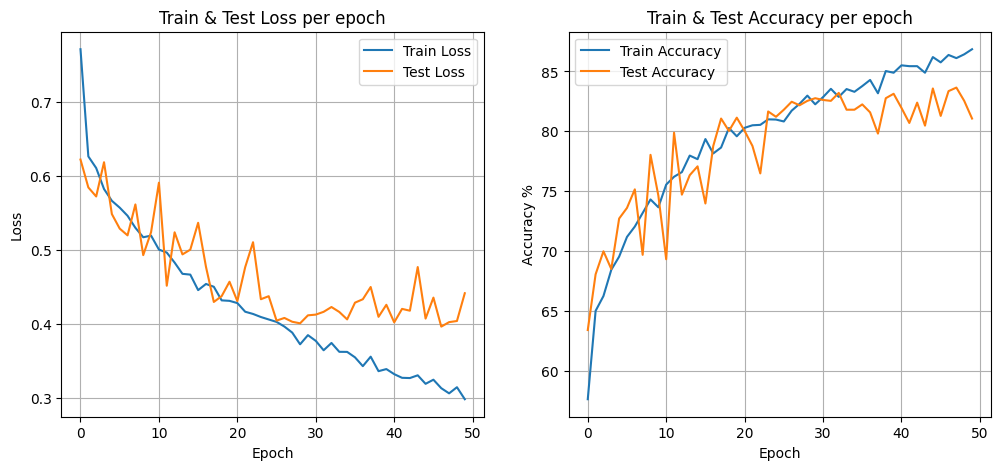

In [346]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [347]:
from torch.utils.data import Subset

In [348]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)